# Linguistic Analyses for Compositional Abstractions (COSMOS)
## Notebook 2: Learning part concepts with program abstraction

In the previous section, we saw that *Architects* used increasingly concise language to describe the scenes they were viewing. In particular, we saw that they started to use words that referred to increasingly complex entities, moving from instructions about individual blocks to entire towers.

Here we try to explain this trend through the lens of *abstraction*. We hypothesize that, as people are exposed to scenes that have elements in common, they acquire a vocabulary of part concepts that they can use represent and talk about each scene more concisely. To formalize this notion, we use *programmatic representations* of scenes, which support and amodal notion of abstraction, in the form of *program fragments*. In this notebook we explore a mechanism for learning program fragments as a model for the acquisition of part concepts.

*Note: this notebook serves as the instructor version and should be altered to the student version before being presented*

This section is divided into three sections.  
**Section 1** explains the programmatic representations we will work with.  
**Section 2** covers the aquisition of part concepts over trials.  
**Section 3** covers the refactoring of scene programs into more concise programs involving these part concepts.

### Setup

In [1]:
import os
import sys
import urllib, io
os.getcwd()

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast
import pickle

import seaborn as sns

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
sys.path.append("./model/lib_learning/")

from program import *
import utilities
import render
from parse import *

from towerPrimitives import primitives
from makeTowerTasks import *
from grammar import *
from fragmentGrammar import *
from gen_seq import *
from enumeration import *
import importlib

## Part 1: Representing block towers as programs

In this project we want to explore how people build on top of existing knowledge over a short interaction. We therefore assume a basic level of understanding of block building concepts, encapsulated in a *domain specific language* (DSL).

Our *base DSL* (adapted from the [Dreamcoder building task](https://arxiv.org/abs/2006.08381)), contains the following primitives:
- **h**: horizontal domino
- **v**: vertical domino
- **l_x**: move left x places,  where x in {1,2,3,4,5,6,7,8,9,10,11,12}
- **r_x**: move right x places, where x in {1,2,3,4,5,6,7,8,9,10,11,12}

We manually define a unique program for each scene. For example, the scene with the C-tower on the left and L-tower on the right is represented as:  
    `h l_1 v v r_1 h r_12 h l_4 h l_1 v v`

In [3]:
manual_tower_programs = {"CL" :"h l_1 v v r_1 h r_12 h l_4 h l_1 v v",
                         "CPi": "h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h",
                         "PiC": "v r_6 v l_5 h r_4 h r_7 h l_1 v v r_1 h",
                         "LPi": "h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h",
                         "LC": "h l_4 h l_1 v v r_12 h l_1 v v r_1 h",
                         "PiL": "v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v"}

### <span style="color: orange"> Possible exercise: follow through the program for a specific scene [include image] to make sure you know how the dsl is implemented </span>

## Part 2: Library learning

In this section we formalize abstraction learning as the discovery of *program fragments*. Fragments express part of a program with a single token. By augmenting the base DSL with these additional program fragments, we create a new DSL that can be used to express scenes more efficiently (i.e. with fewer tokens). This benefit comes at the cost of storing the new abstractions in memory.

This trade-off is captured by the abstraction learning algorithm, [Dreamcoder](https://arxiv.org/abs/2006.08381). Dreamcoder proposes program fragments more or less readily, depending on a weighting parameter, *w*. To keep things simple, here we consider a small range of *w*s that produce a reasonable range of learning rates.

This is important, as we use Dreamcoder to capture the *change in DSLs* across trials. As the model is exposed to more scenes (programs), program fragments are added to the DSL, and scenes are able to be expressed with shorter programs. This is meant to capture the ability of participants to reason about structures larger than individual blocks.

### Running dreamcoder

To save time, we have run the library learning phase of Dreamcoder for you on a range of weights. 

The output of Dreamcoder, for each participant, for each weight, is a series of DSLs-- one for each trial.

These DSLs are saved in `./data/model/dsls/`.

In [4]:
ws = [1.5, 3.2, 3.3, 9.6] # values of w for which dreamcoder was run
w_index = {w: i for i, w in enumerate(ws)} # positional index of w
trials = range(1,13)
ppts = range(1,50)

In [5]:
# Read in the DSLs learned by dreamcoder

data_path = './data/model/dsls/'

dsls = {}
trial_seqs = {}

for ppt in range(1,50):
    
    dsls[ppt] = {}
    
    # read participants' trial sequence
    with open(data_path+f"{ppt}/configs.p", "rb") as config_file:
            trial_seqs[ppt] = pickle.load(config_file)
    
    # read inferred DSLs
    for trial in range(1, 13):
        with open(data_path+f"{ppt}/{trial}.p", "rb") as input_file:
            dsls[ppt][trial] = pickle.load(input_file)

In [8]:
# inspect libraries learned for a particular participant, trial, and w

ppt = 1
trial = 12
w = 3.2

[parse(str(fragment), base_dsl_only=True) for fragment in dsls[ppt][trial][w_index[w]]]

['v r_6 v l_5 h r_4 h', 'h l_1 v v', 'h l_4 h l_1 v v', 'h l_1 v v r_1 h']

The `parse()` function is doing some basic translation between our DSL and the language that Dreamcoder works with.

We're currently displaying each fragment as a program in the base DSL, but the whole point of learning fragments is that you can express them as a single token.

If we were fully automating this process, we might use an ID to label each learned fragment. In this example, only a handful of fragments are learned. This makes it possible to give each fragment a more helpful, human-readable name. We've created a lookup table to do just that, which is built in to our parsing function. If we change `base_dsl_only` to `False` then we can give these learned fragments helpful names

In [9]:
[parse(str(fragment), base_dsl_only=False) for fragment in dsls[ppt][trial][w_index[w]]]

['chunk_Pi', 'chunk_8', 'chunk_L', 'chunk_C']

We refer to all these learned abstractions as "chunks". 

`chunk_Pi`, `chunk_C` and `chunk_L`, are our block towers!  
`chunk_8` and `chunk_8b` are subtower expressions, and in fact do the same thing: place a horizontal block, then stack two vertical blocks the left hand side.

### <span style="color: orange"> Possible exercise: search through the libraries learned for a few participants. How different are they? Would you expect them to be like this? </span>

In [10]:
# Find the series of libraries for a specific weight and participant

ppt = 1
w = 3.2

{trial : [parse(str(fragment), 
                base_dsl_only = False)
          for fragment in dsls[ppt][trial][w_index[w]]] 
             for trial in trials}

{1: [],
 2: [],
 3: ['chunk_8b'],
 4: ['chunk_8b', 'chunk_Pi'],
 5: ['chunk_8', 'chunk_Pi', 'chunk_L', 'chunk_C'],
 6: ['chunk_Pi', 'chunk_8', 'chunk_L', 'chunk_C'],
 7: ['chunk_8', 'chunk_Pi', 'chunk_L', 'chunk_C'],
 8: ['chunk_8', 'chunk_Pi', 'chunk_L', 'chunk_C'],
 9: ['chunk_Pi', 'chunk_8', 'chunk_L', 'chunk_C'],
 10: ['chunk_8', 'chunk_Pi', 'chunk_L', 'chunk_C'],
 11: ['chunk_Pi', 'chunk_8', 'chunk_L', 'chunk_C'],
 12: ['chunk_Pi', 'chunk_8', 'chunk_L', 'chunk_C']}

In [ ]:
# parse failure with w=1.5 (haven't defined chunks for these fragments)

# ppt = 10
# w = 1.5

# {trial : [parse(str(fragment), 
#                 base_dsl_only = False)
#           for fragment in dsls[ppt][trial][w_index[w]]] 
#              for trial in trials}

In [11]:
# We see that with a larger weight (i.e. higher penalty for adding chunks to the library) fewer chunks are learned.
# Only one tower-level expression is learned.

ppt = 1
w = 9.6

{trial : [parse(str(fragment), 
                base_dsl_only = False)
          for fragment in dsls[ppt][trial][w_index[w]]] 
             for trial in trials}

{1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: ['chunk_8'],
 9: ['chunk_8', 'chunk_9'],
 10: ['chunk_8', 'chunk_9'],
 11: ['chunk_8', 'chunk_9'],
 12: ['chunk_8', 'chunk_Pi']}

1. Library size
2. Library content
3. 

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_69256/102935760.py:150: RuntimeWarning: invalid value encountered in divide
  ffrags_low = ffrags_low_sum/low
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_69256/102935760.py:151: RuntimeWarning: invalid value encountered in divide
  ffrags_med = ffrags_med_sum/med
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_69256/102935760.py:152: RuntimeWarning: invalid value encountered in divide
  ffrags_high = ffrags_high_sum/high
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_69256/102935760.py:153: RuntimeWarning: invalid value encountered in divide
  ttowers_low = ttowers_low_sum/low
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_69256/102935760.py:154: RuntimeWarning: invalid value encountered in divide
  ttowers_med = ttowers_med_sum/med
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_69256/102935760.py:155: RuntimeWarning: invalid value encountered in divide
  ttowers_hig

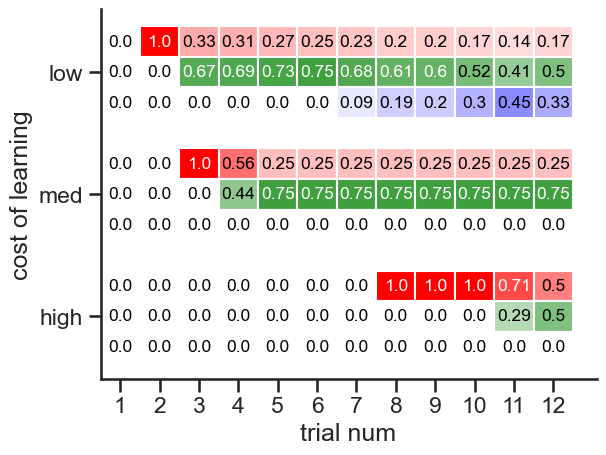

In [12]:
# Visualize the breakdown of expressions learned in each run of dreamcoder (with different ws).
# move to file

import pickle
from makeTowerTasks import *
from render import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re
sns.set()

sys.path.append('..')

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

def get_freq(chunk):
    pair = 0
    tower = 0
    frag = 0
    for item in chunk:
        if str(item.body) in lookup.keys():
            item = lookup[str(item.body)]
            for t in item:
                if t.name == 'C': 
                    tower += 1.
                elif t.name == 'L': 
                    tower += 1.
                elif t.name == 'Pi': 
                    tower += 1.
                elif t.name == 'CL': 
                    pair += 1.
                elif t.name == 'CPi': 
                    pair += 1.
                elif t.name == 'LC': 
                    pair += 1.
                elif t.name == 'LPi': 
                    pair += 1.
                elif t.name == 'PiC': 
                    pair += 1.
                elif t.name == 'PiL': 
                    pair += 1.
                elif t.name == '8': 
                    frag += 1.
                elif t.name == '8b': 
                    frag += 1.
                elif t.name == '7': 
                    frag += 1.
                elif t.name == '6': 
                    frag += 1.
                elif t.name == '5': 
                    frag += 1.
                elif t.name == '4': 
                    frag += 1.
                elif t.name == '3': 
                    frag += 1.
                elif t.name == '2': 
                    frag += 1.
                elif t.name == '1': 
                    frag += 1.

    return frag, tower, pair

path = './data/model/dsls/'

ffrags_low_mean = []
ffrags_med_mean = []
ffrags_high_mean = []
ttowers_low_mean = []
ttowers_med_mean = []
ttowers_high_mean = []
ppairs_low_mean = []
ppairs_med_mean = []
ppairs_high_mean = []

lst = sorted_alphanumeric(os.listdir(path))
for dirname in lst:
    ffrags_low = []
    ffrags_med = []
    ffrags_high = []
    ttowers_low = []
    ttowers_med = []
    ttowers_high = []
    ppairs_low = []
    ppairs_med = []
    ppairs_high = []

    data_path = path + dirname + '/'
    # print(data_path)
    for name in range(1, 13):
        with open(data_path+f"{name}.p", "rb") as input_file:
            e = pickle.load(input_file)

        for i, w in enumerate(range(len(e))):
            if i == 0:
                frag, tower, pair = get_freq(e[w])
                ffrags_low.append(frag)
                ttowers_low.append(tower)
                ppairs_low.append(pair)
            elif i == 1:
                frag, tower, pair = get_freq(e[w])
                ffrags_med.append(frag)
                ttowers_med.append(tower)
                ppairs_med.append(pair)
            elif i == 3:
                frag, tower, pair = get_freq(e[w])
                ffrags_high.append(frag)
                ttowers_high.append(tower)
                ppairs_high.append(pair)
    ffrags_low_mean.append(ffrags_low)
    ffrags_med_mean.append(ffrags_med)
    ffrags_high_mean.append(ffrags_high)
    ttowers_low_mean.append(ttowers_low)
    ttowers_med_mean.append(ttowers_med)
    ttowers_high_mean.append(ttowers_high)
    ppairs_low_mean.append(ppairs_low)
    ppairs_med_mean.append(ppairs_med)
    ppairs_high_mean.append(ppairs_high)

ffrags_low_mean = np.array(ffrags_low_mean)
ffrags_med_mean = np.array(ffrags_med_mean)
ffrags_high_mean = np.array(ffrags_high_mean)
ttowers_low_mean = np.array(ttowers_low_mean)
ttowers_med_mean = np.array(ttowers_med_mean)
ttowers_high_mean = np.array(ttowers_high_mean)
ppairs_low_mean = np.array(ppairs_low_mean)
ppairs_med_mean = np.array(ppairs_med_mean)
ppairs_high_mean = np.array(ppairs_high_mean)

ffrags_low_sum = ffrags_low_mean.sum(axis=0)
ffrags_med_sum = ffrags_med_mean.sum(axis=0)
ffrags_high_sum = ffrags_high_mean.sum(axis=0)
ttowers_low_sum = ttowers_low_mean.sum(axis=0)
ttowers_med_sum = ttowers_med_mean.sum(axis=0)
ttowers_high_sum = ttowers_high_mean.sum(axis=0)
ppairs_low_sum = ppairs_low_mean.sum(axis=0)
ppairs_med_sum = ppairs_med_mean.sum(axis=0)
ppairs_high_sum = ppairs_high_mean.sum(axis=0)

low = np.vstack([ffrags_low_sum, ttowers_low_sum, ppairs_low_sum])
med = np.vstack([ffrags_med_sum, ttowers_med_sum, ppairs_med_sum])
high = np.vstack([ffrags_high_sum, ttowers_high_sum, ppairs_high_sum])

low = low.sum(axis=0)
med = med.sum(axis=0)
high = high.sum(axis=0)

ffrags_low = ffrags_low_sum/low
ffrags_med = ffrags_med_sum/med
ffrags_high = ffrags_high_sum/high
ttowers_low = ttowers_low_sum/low
ttowers_med = ttowers_med_sum/med
ttowers_high = ttowers_high_sum/high
ppairs_low = ppairs_low_sum/low
ppairs_med = ppairs_med_sum/med
ppairs_high = ppairs_high_sum/high

where_are_NaNs = np.isnan(ffrags_low)
ffrags_low[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ffrags_med)
ffrags_med[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ffrags_high)
ffrags_high[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ttowers_low)
ttowers_low[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ttowers_med)
ttowers_med[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ttowers_high)
ttowers_high[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ppairs_low)
ppairs_low[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ppairs_med)
ppairs_med[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ppairs_high)
ppairs_high[where_are_NaNs] = 0

df_const = np.array([ffrags_high, ffrags_med, ffrags_low])
df_one = np.array([ttowers_high, ttowers_med, ttowers_low])
df_two = np.array([ppairs_high, ppairs_med, ppairs_low])

xticks = ['high', 'med', 'low']
with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")        

    # plot details
    bar_width = 0.25
    two_bar_positions = np.arange(3)
    one_bar_positions = two_bar_positions + bar_width
    const_bar_positions = one_bar_positions + bar_width

    rgba_colors_const = np.zeros((3,4))
    rgba_colors_const[:,0] = 1.0
    rgba_colors_one = np.zeros((3,4))
    rgba_colors_one[:,1] = 0.5019607843137255
    rgba_colors_two = np.zeros((3,4))
    rgba_colors_two[:,2] = 1.0

    for i in range(12):
        rgba_colors_const[:, 3] = df_const[:,i]
        rgba_colors_one[:, 3] = df_one[:,i]
        rgba_colors_two[:, 3] = df_two[:,i]
        const_labels = [str(x) for x in rgba_colors_const]
        one_labels = [str(x) for x in rgba_colors_one]
        two_labels = [str(x) for x in rgba_colors_two]

        const_bar = plt.barh(const_bar_positions, [1, 1, 1], bar_width,
                                color=rgba_colors_const,
                                left=i*1,
                                tick_label=const_labels)
        for j, p in enumerate(const_bar.patches):
            if rgba_colors_const[j][3]>=0.6:
                clr = 'white'
            else:
                clr = 'black'
            plt.text(p.get_x()+0.5*p.get_width(),p.get_y()+0.5*p.get_height(),str(round(rgba_colors_const[j][3],2)),color=clr,ha='center', va='center', fontsize=12.5)
        one_bar = plt.barh(one_bar_positions, [1, 1, 1], bar_width,
                                color=rgba_colors_one,
                                left=i*1,
                                tick_label=one_labels)
        for j, p in enumerate(one_bar.patches):
            if rgba_colors_one[j][3]>=0.6:
                clr = 'white'
            else:
                clr = 'black'
            plt.text(p.get_x()+0.5*p.get_width(),p.get_y()+0.5*p.get_height(),str(round(rgba_colors_one[j][3],2)),color=clr,ha='center', va='center', fontsize=12.5)
        two_bar = plt.barh(two_bar_positions, [1, 1, 1], bar_width,
                                color=rgba_colors_two,
                                left=i*1,
                                tick_label=two_labels)
        for j, p in enumerate(two_bar.patches):
            if rgba_colors_two[j][3]>=0.6:
                clr = 'white'
            else:
                clr = 'black'
            plt.text(p.get_x()+0.5*p.get_width(),p.get_y()+0.5*p.get_height(),str(round(rgba_colors_two[j][3],2)),color=clr,ha='center', va='center', fontsize=12.5)
    plt.yticks(one_bar_positions, xticks)
    plt.xticks(np.arange(0.5, 12, step=1), [x for x in np.arange(1, 13, step=1)])
    plt.xlabel('trial num')
    plt.ylabel('cost of learning')
    const_patch = mpatches.Patch(color='red', label='const')
    one_patch = mpatches.Patch(color='green', label='one')
    two_patch = mpatches.Patch(color='blue', label='two')
    # plt.legend(handles=[const_patch, two_patch, one_patch], bbox_to_anchor=(.91, .55))
    sns.despine()  
    plt.show()
#     plt.savefig('/Users/cogtoolslab/Desktop/fig.pdf')
#     plt.savefig('~/compositional-abstractions/figures/cogsci21_fragments_all_sequences.pdf')


## Part 3: Representing scenes more concisely with refactored programs

Now we have inferred the libraries of part concepts available to each participant in each trial. These part concepts, or program fragments, allow each scene program to be expressed more efficiently. In the next notebook, the model makes a decision about whether to use the most efficient program available to it, or play it safe and use lower-level language (about individual blocks). Before we get there, we first need to find these efficient programs.

How to search for programs given a DSL is an interesting research question in itself. Here, however, our focus is on how people choose between more or less efficient ways of expressing a concept, given uncertainty about what their partner will understand. For our purposes, we just need to select the single most efficient program that represents each scene. Fortunately for us, Dreamcoder libraries uniquely determine this most efficient programs. Programs involving larger abstractions can easily be found through enumeration. For less compressed programs, enumeration takes too long, however, we can simply swap in the learned abstractions from our DSLs through string-matching.

In [13]:
w = 3.3
w_position = w_index[w]

# ground-truth programs fed into library learning
tower_strings = {"CL" :"(h (l 1) v v (r 1) h (r 12) h (l 4) h (l 1) v v)",
                "CPi": "(h (l 1) v v (r 1) h (r 6) v (r 6) v (l 5) h (r 4) h)",
                "LPi": "(h (l 4) h (l 1) v v (r 9) v (r 6) v (l 5) h (r 4) h)",
                "LC": "(h (l 4) h (l 1) v v (r 12) h (l 1) v v (r 1) h)",
                "PiC": "(v (r 6) v (l 5) h (r 4) h (r 7) h (l 1) v v (r 1) h)",
                "PiL": "(v (r 6) v (l 5) h (r 4) h (r 9) h (l 4) h (l 1) v v)"}


# base dsl for webppl-readable strings
base_dsl = ['h', 
 'v', 
 'l_0',
 'l_1',
 'l_2',
 'l_3',
 'l_4',
 'l_5',
 'l_6',
 'l_7',
 'l_8',
 'l_9',
 'l_10',
 'l_11',
 'l_12',
 'r_0',
 'r_1',
 'r_2',
 'r_3',
 'r_4',
 'r_5',
 'r_6',
 'r_7',
 'r_8',
 'r_9',
 'r_10',
 'r_11',
 'r_12']

In [14]:
def get_partially_chunked_programs(trial_datum):
    '''
    This helper function converts minimum length programs into longer versions that replace each chunk with its base-DSL equivalent.
    '''
    
    chunk_lambdas = trial_datum['dsl_lambda'][16:]
    chunk_names = trial_datum['chunks']

    progs = [trial_datum['min_program']]

    for prog in progs:
        for i, chunk_name in enumerate(chunk_names):
            new_prog = prog.replace(chunk_name, parse(chunk_lambdas[i], base_dsl_only=True))
            if not(new_prog in progs):
                progs.append(new_prog)
    
    progs_with_length = {p: len(p.split(' ')) for p in progs}
    return progs_with_length


In [15]:
manual_tower_programs

{'CL': 'h l_1 v v r_1 h r_12 h l_4 h l_1 v v',
 'CPi': 'h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h',
 'PiC': 'v r_6 v l_5 h r_4 h r_7 h l_1 v v r_1 h',
 'LPi': 'h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h',
 'LC': 'h l_4 h l_1 v v r_12 h l_1 v v r_1 h',
 'PiL': 'v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v'}

In [16]:
# loop over all participants

verbose = False

for ppt in range(1,50):
    
    trial_data = []

    # towerpairs plus trial numbers
    trial_tasks = [SupervisedTower(tower_pair + str(i+1), tower_strings[tower_pair]) for i, tower_pair in enumerate(trial_seqs[ppt])]

    # get dsls for all trials
    trial_grammars = {trial_tasks[i]: Grammar.uniform(primitives + dsls[ppt][i][w_position]) for i in range (1,12)}
    trial_grammars[trial_tasks[0]] = Grammar.uniform(primitives)
    
    for trial_num in range(1,13):
        
        scene = trial_seqs[ppt][trial_num-1] # get trial scene
        if verbose: print(scene)
        chunks = list(map(lambda x: parse(str(x)), trial_grammars[trial_tasks[trial_num-1]].primitives[16:]))
        manual_program = manual_tower_programs[scene]
        min_program = manual_program

        if len(dsls[ppt][trial_num][w_position]) == 0: # if no chunks learned, take input program
            
            if verbose: print(min_program)

        else: # if some chunks learned, swap in chunks into input program

            # find translation between dsl substring and chunk
            chunk_tranlations_trimmed = list(map(lambda x: parse(str(x), base_dsl_only=True), dsls[ppt][trial_num-1][w_position]))

            # order chunks from largest to smallest
            chunk_dict = {chunks[i]: chunk_tranlations_trimmed[i] for i in range(0, len(chunks))}
            sorted_chunk_dict = sorted(chunk_dict.items(), key=lambda item: len(item[1].split()), reverse=True)
            if verbose: print(sorted_chunk_dict)

            # start with base dsl program
            chunked_program = manual_program
                
            # swap chunks in from largest to smallest
            for key, value in sorted_chunk_dict:
                chunked_program = chunked_program.replace(value, key)
            
            if verbose:
                print('manual:', manual_program)
                print('chunked:', chunked_program)
            
            min_program = chunked_program


        trial_data.append(
            {
            'ppt' : ppt, # just added
            'trial_num': trial_num,
            'towers': scene,
            'dsl_lambda': [str(p) for p in trial_grammars[trial_tasks[trial_num-1]].primitives],
            'chunks': chunks,
            'dsl': base_dsl + list(map(lambda s: parse(str(s)), trial_grammars[trial_tasks[trial_num-1]].primitives[16:])),
            #         'trial_programs': trial_programs_sorted,
            'min_program': min_program
            })
    
    # find programs with abstractions replaced with base dsl only
    for i, trial_datum in enumerate(trial_data):
        trial_datum['programs_with_length'] = get_partially_chunked_programs(trial_datum)

#     # # This will save results within lib-learning directory. 
    with open("../demo/data/model/programs/programs_ppt_" + str(ppt) + ".json", "w") as write_file:
         json.dump(trial_data, write_file)
    


### <span style="color: orange"> Possible exercise: how does the length of the minimum length program change across trials? Is this what you expect? Compare these results with the human results in the previous notebook. </span>

In [17]:
ppt = 4

with open("../demo/data/model/programs/programs_ppt_" + str(ppt) + ".json", "r") as read_file:
    trial_data = json.load(read_file)

In [18]:
[trial['min_program'] for trial in trial_data]

['h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h',
 'h l_4 h l_1 v v r_12 h l_1 v v r_1 h',
 'h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h',
 'chunk_8b r_1 h r_12 h l_4 chunk_8b',
 'v r_6 v l_5 h r_4 h r_9 h l_4 chunk_8',
 'chunk_Pi r_4 h r_7 chunk_C',
 'chunk_L r_9 chunk_Pi',
 'chunk_C r_6 chunk_Pi',
 'chunk_L r_12 chunk_C',
 'chunk_Pi r_7 chunk_C',
 'chunk_C r_12 chunk_L',
 'chunk_Pi r_9 chunk_L']

In [19]:
trial_data

[{'ppt': 4,
  'trial_num': 1,
  'towers': 'CPi',
  'dsl_lambda': ['2x1',
   '1x2',
   '1',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9',
   '10',
   '11',
   '12',
   'left',
   'right'],
  'chunks': [],
  'dsl': ['h',
   'v',
   'l_0',
   'l_1',
   'l_2',
   'l_3',
   'l_4',
   'l_5',
   'l_6',
   'l_7',
   'l_8',
   'l_9',
   'l_10',
   'l_11',
   'l_12',
   'r_0',
   'r_1',
   'r_2',
   'r_3',
   'r_4',
   'r_5',
   'r_6',
   'r_7',
   'r_8',
   'r_9',
   'r_10',
   'r_11',
   'r_12'],
  'min_program': 'h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h',
  'programs_with_length': {'h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h': 14}},
 {'ppt': 4,
  'trial_num': 2,
  'towers': 'LC',
  'dsl_lambda': ['2x1',
   '1x2',
   '1',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9',
   '10',
   '11',
   '12',
   'left',
   'right'],
  'chunks': [],
  'dsl': ['h',
   'v',
   'l_0',
   'l_1',
   'l_2',
   'l_3',
   'l_4',
   'l_5',
   'l_6',
   'l_7',
   'l_8',
   'l_9',
   'l_10